# Evaluate Grid Cell Elevation

__Author__: Pat McCornack

__Date__: 01/01/25

__About__: Analysis of the actual elevation of each site vs. the grid cell elevation for each site. 

Elevations were extracted from a 1m resolution DEM of Santa Cruz Island for each site. 

__Sites__: 
- Sauces:  34° 0'3.72"N, 119°49'4.14"W (LAT: 34.001033, LONG: -119.817817)
- UPEM:  34° 0'45.11"N, 119°48'6.58"W (LAT: 34.012531, LONG: -119.801828)
- NRS SCI: LAT: 33.995943, LONG: -119.716437

In [1]:
import os 
import glob 

import numpy as np
import pandas as pd
import xarray as xr
import netCDF4

import matplotlib.pyplot as plt
from   matplotlib.lines import Line2D

# Prepare Data

## Prepare Terrain/Land Mask

In [2]:
#### 
#  Open geogrid file
file     = '/home/sbarc/wrf/wrf401/sbareg/geo_em.d04.nc'
ds       = xr.open_dataset(file)
ds

#   read one 2DVar file to get coordinates
path     = '/home/sbarc/wrf/wrf401/sbareg/'
yr1      = 1988
m        = 0
files    = sorted(glob.glob(path + str(yr1+m) + '/wrfout_d04_2DVar_*.nc'))
f2       = xr.open_dataset(files[m])

#   creat xarray
terrain  = xr.DataArray(ds['HGT_M'][0,:,:].values, dims =("south_north","west_east"), name="terrain",     
                    coords={"XLAT":f2['XLAT'],"XLONG":f2['XLONG']},
                    attrs ={'terrain':'elevation (m)'})
#   creat landmask
landmask = xr.DataArray(ds['LANDMASK'][0,:,:].values, dims =("south_north","west_east"), name="landmask",     
                    coords={"XLAT":f2['XLAT'],"XLONG":f2['XLONG']},
                    attrs ={'landmask':'landmask (m)'})

In [3]:
f2

<xarray.Dataset>
Dimensions:   (Time: 24, bottom_top: 54, south_north: 234, west_east: 258)
Coordinates:
    XLAT      (south_north, west_east) float32 ...
    XLONG     (south_north, west_east) float32 ...
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Data variables:
    HGT       (south_north, west_east) float32 ...
    Times     (Time) |S19 ...
    Q2        (Time, south_north, west_east) float32 ...
    T2        (Time, south_north, west_east) float32 ...
    TH2       (Time, south_north, west_east) float32 ...
    PSFC      (Time, south_north, west_east) float32 ...
    U10       (Time, south_north, west_east) float32 ...
    V10       (Time, south_north, west_east) float32 ...
    FGDP      (Time, south_north, west_east) float32 ...
    DFGDP     (Time, south_north, west_east) float32 ...
    VDFG      (Time, south_north, west_east) float32 ...
    RAINNC    (Time, south_north, west_east) float32 ...
    I_RAINNC  (Time, south_north, west_east) int32 ...
    CLDFRA    (Time, bottom_top, south_north, west_east) float32 ...
    LWUPB     (Time, south_north, west_east) float32 ...
    LWDNB     (Time, south_north, west_east) float32 ...
    SWUPB     (Time, south_north, west_east) float32 ...
    SWDNB     (Time, south_north, west_east) float32 ...
    UST       (Time, south_north, west_east) float32 ...
    HFX       (Time, south_north, west_east) float32 ...
    QFX       (Time, south_north, west_east) float32 ...
    LH        (Time, south_north, west_east) float32 ...
    GRDFLX    (Time, south_north, west_east) float32 ...
    PBLH      (Time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V4.0.1 MODEL
    START_DATE:                      1987-07-01_00:00:00
    SIMULATION_START_DATE:           1987-07-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        259
    SOUTH-NORTH_GRID_DIMENSION:      235
    BOTTOM-TOP_GRID_DIMENSION:       55
    DX:                              1000.0
    DY:                              1000.0
    AERCU_OPT:                       0
    AERCU_FCT:                       1.0
    IDEAL_CASE:                      0
    DIFF_6TH_SLOPEOPT:               0
    AUTO_LEVELS_OPT:                 2
    DIFF_6TH_THRESH:                 0.1
    DZBOT:                           50.0
    DZSTRETCH_S:                     1.3
    DZSTRETCH_U:                     1.1
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        2
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      6
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               5
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  5
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     1
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_SURFACE_MOSAIC:               0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        1
    SMOOTH_OPTION:                   0
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       0
    DT:                              3.3333333
    RADT:                            10.0
    BLDT:      

## Select Domain to Crop
Crop WRF data to SCI

In [4]:
#### Define geographic domain ####
i1 = 20
i2 = 135
j1 = 50
j2 = 199

In [5]:
#### Crop terrain and landmask ####
terrain  = terrain[i1:i2+1,j1:j2+1]
landmask = landmask[i1:i2+1,j1:j2+1]
landmask.shape

(116, 150)

# Extract Elevations

In [6]:
## Define sites

In [7]:
sauc_site_dict = {
    'name' : 'sauc',
    'xlat' : 34.001033,
    'xlon' : -119.817817
}

upem_site_dict = {
    'name' : 'upem',
    'xlat' : 34.012531,
    'xlon' : -119.801828
}

nrs_site_dict = {
    'name' : 'nrs_sci',
    'xlat' : 33.995943,
    'xlon' : -119.716437
}

In [8]:
## Get Elevations

In [9]:
def extract_dataframe(xrstack, terrain, xlat, xlon, interp):
    # Find closest WRF cell to station
    slat = xrstack['XLAT'].values
    slon = xrstack['XLONG'].values
    dist = np.sqrt((slat - xlat)**2 + (slon - xlon)**2)
    ind  = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
    np.shape(slat),np.shape(slon),np.shape(dist),ind
    
    # Extract data - interpolate or use nearest neighbor
    if interp == True:
        darray = interp_value(xrstack, dist, xlat, xlon)
        # Drop variables
        darray = darray.drop('south_north')
        darray = darray.drop('west_east')
    else:
        darray = xrstack[:,ind[0],ind[1]]
        
    darray  = darray.drop('XLAT')
    darray  = darray.drop('XLONG')
    df = darray.to_dataframe()
    elev = terrain[ind[0],ind[1]].values
    return df

slat = terrain

In [10]:
def get_elev(site_dict):
    xlat = site_dict['xlat']
    xlon = site_dict['xlon']
    site = site_dict['name']

    slat = terrain['XLAT'].values
    slon = terrain['XLONG'].values
    dist = np.sqrt((slat - xlat)**2 + (slon - xlon)**2)
    ind  = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
    elev = terrain[ind[0],ind[1]].values
    
    print(f"{site}: {elev}m")
    return dist
    
sauc_dist = get_elev(sauc_site_dict)
upem_dist = get_elev(upem_site_dict)
nrs_dist = get_elev(nrs_site_dict)

sauc: 266.1056213378906m
upem: 327.22607421875m
nrs_sci: 156.2794189453125m


In [11]:
def interp_elevations(terrain, dist, site_dict):
    # Assign labels to coords
    ds = terrain
    lats = ds['XLAT'].values[:,0]
    lons = ds['XLONG'][0]
    
    target_lat = site_dict['xlat']
    target_lon = site_dict['xlon']

    ds = ds.assign_coords({'south_north':('south_north', lats)})
    ds = ds.assign_coords({'west_east':('west_east', lons)})

    # Find 4 nearest points to target
    flat_indices = np.argsort(dist.ravel())[:3]
    indices = np.unravel_index(flat_indices, dist.shape)

    # Get bounding box to crop dataset
    near_lats = ds['XLAT'].values[indices[0], indices[1]]
    near_lons = ds['XLONG'].values[indices[0], indices[1]]

    max_lat = np.max(near_lats)
    min_lat = np.min(near_lats)
    max_lon = np.max(near_lons)
    min_lon = np.min(near_lons)

    # Crop dataset to locality of target
    ds_local = ds.sel(south_north=slice(min_lat,max_lat), west_east=slice(min_lon,max_lon))
    
    print(site_dict['name'])
    results = []
    for i in [0, 1]:
        for j in [0, 1]:
            elev = round(float(ds_local[i][j].values), 2)
            lat = round(float(ds_local[i][j]['XLAT'].values), 4)
            lon = round(float(ds_local[i][j]['XLONG'].values), 4)
            print(f"{lat}, {lon}: {elev}m")
            results.append([lat, lon, elev])
    
    df = pd.DataFrame(results, columns=['latitude', 'longitude', 'elevation'])
    print("\n")
                      
    return df

In [12]:
df = interp_elevations(terrain, sauc_dist, sauc_site_dict)
df
#interp_elevations(terrain, upem_dist, upem_site_dict)
#interp_elevations(terrain, nrs_dist, nrs_site_dict)

sauc
34.0008, -119.8205: 266.11m
34.0008, -119.8101: 244.33m
34.0095, -119.8205: 269.14m
34.0095, -119.8101: 299.51m




,latitude,longitude,elevation
0,34.0008,-119.8205,266.11
1,34.0008,-119.8101,244.33
2,34.0095,-119.8205,269.14
3,34.0095,-119.8101,299.51


# Visualize elevation profiles 

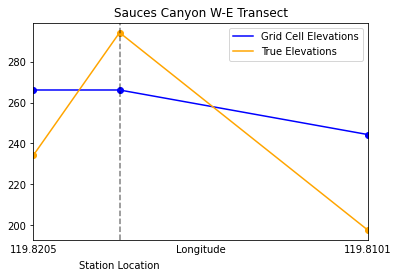

In [13]:
# Plot sauc line along 34.0008
# Normalize x axis


def plot_transect(coords, grid_elev, true_elev, xlab, title):
    diff = coords[0] - coords[2]
    ind = [(x - coords[2])/diff for x in coords]

    fig, ax = plt.subplots()
    ax.plot(ind, grid_elev, color='blue', label='Grid Cell Elevations')
    ax.plot(ind, true_elev, color='orange', label='True Elevations')
    ax.scatter(ind, grid_elev, color='blue')
    ax.scatter(ind, true_elev, color='orange')

    ax.set_xlim(1, 0)
    ax.axvline(x=ind[1], color='black', linestyle='--', alpha=0.5)
    ax.text(ind[1], ax.get_ylim()[0] - 14, 'Station Location', color='black', ha='center')
    ax.text(ind[0], ax.get_ylim()[0] - 6, coords[0], color='black', ha='center')
    ax.text(ind[2], ax.get_ylim()[0] - 6, coords[2], color='black', ha='center')

    ax.set_xticks([])
    ax.set_xlabel(xlab)
    ax.legend()

    ax.set_title(title)
    plt.show()
    
title = "Sauces Canyon W-E Transect"
lons = [119.8205, 119.817817, 119.8101]
grid_elev = [266.11, 266.11, 244.33]
true_elev = [234.12, 294.15, 197.61]
plot_transect(lons, grid_elev, true_elev, 'Longitude', title)

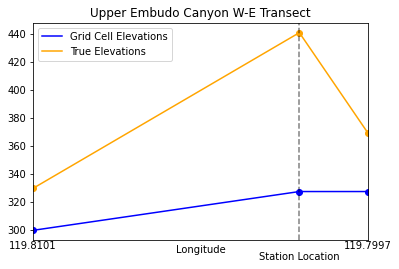

In [14]:
title = "Upper Embudo Canyon W-E Transect"
lons = [119.8101, 119.801828, 119.7997]
grid_elev = [299.51, 327.23, 327.23]
true_elev = [329.53, 440.78, 369.12]
plot_transect(lons, grid_elev, true_elev, 'Longitude', title)

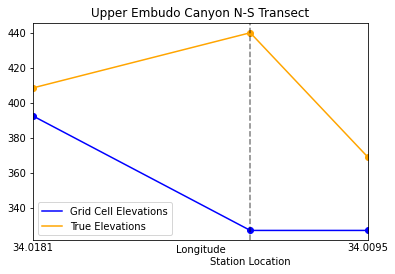

In [15]:
title = "Upper Embudo Canyon N-S Transect"
lats = [34.0181, 34.012521, 34.0095]
grid_elev = [392.63, 327.23, 327.23]
true_elev = [408.72, 440.23, 369.12]
plot_transect(lats, grid_elev, true_elev, 'Longitude', title)